In [56]:
#Importing libraries
import time
import cv2
import os
from PIL import Image
import numpy as np
import re
from natsort import natsorted
import yaml
from collections import defaultdict
import imagehash
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from astropy.convolution import Gaussian2DKernel
from matplotlib.colors import LinearSegmentedColormap


In [57]:

target_folder=r"M:\Thesis\Dataset\uk1\try6\org"
zoomed_folder = r"M:\Thesis\Dataset\uk1\try6\zoomed"
video=r"M:\Thesis\Dataset\uk1\proj1\user\0003-scrn.avi"

input_yml_file = r"M:\Thesis\Dataset\uk1\proj1\user\0003-user.yml\0003-user.yml"
output_yml_file = r"M:\Thesis\Dataset\uk1\proj1\user\0003-user.yml\median.yml"
output_file =r"M:\Thesis\Dataset\uk1\proj1\user\0003-user.yml\final.yml"


In [58]:

### VIDEO TO FRAMES
# Record the start time
start_time = time.time()
#Video from gaze tracker
cam = cv2.VideoCapture(video)

try:
    # creating a folder named data  
 if not os.path.exists(zoomed_folder):
        os.makedirs(zoomed_folder)
        print("making folder")
  
# if not created then raise error
except OSError:
 print ('Error: Creating directory of data')
    
currentframe=0
while(True):
      
# reading from frame
 ret,frame = cam.read()
  
 if ret:
        # if video is still left continue creating images
        name = "M:\\Thesis\\Dataset\\uk1\\try6\\zoomed\\frame" + str(currentframe) + '.jpg'
        print ('Creating...' + name)
  
        # writing the extracted images
        cv2.imwrite(name, frame)
  
        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
 else:     
        
        break
  
cam.release()
cv2.destroyAllWindows()


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame0.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame1.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame2.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame3.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame4.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame5.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame6.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame7.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame8.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame9.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame10.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame11.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame12.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame13.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame14.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame15.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoomed\frame16.jpg
Creating...M:\Thesis\Dataset\uk1\try6\zoo

In [59]:
def parse_value(value):
    """Parse a value from the string, handling different types."""
    try:
        return int(value)
    except ValueError:
        try:
            return float(value)
        except ValueError:
            return value

def read_and_extract_fpog(filepath, marker="Data:"):
    data_started = False
    extracted_data = []
    current_fpogx = None
    current_fpogy = None
    current_scn=None
    
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not data_started:
                if marker in line:
                    data_started = True
                continue

            if not line or ':' not in line:
                continue

            key_values = line.split(',')
            #print(key_values)
            record = {}
            for kv in key_values:
                if ':' in kv:
                    key, value = kv.split(':', 1)
                    key = key.strip()
                    value = value.strip()
                    parsed_value = parse_value(value)
                    record[key] = parsed_value
            #print(record)
            # Check and update the current FPOGX and FPOGY values
            if 'FPOGX' in record:
                current_fpogx = record['FPOGX']
                #print("x",current_fpogx)
            if 'FPOGY' in record:
                current_fpogy = record['FPOGY']
                #print("y",current_fpogy)
            if 'SCN' in record:
                current_scn = record['SCN']
                #print("scn",current_scn)
                   
            # If both values are present, add to extracted_data and reset
            if current_fpogx is not None and current_fpogy is not None and current_scn is not None:
                extracted_data.append({
                    'FPOGX': current_fpogx,
                    'FPOGY': current_fpogy,
                    'SCN': current_scn
                } )        
                current_fpogx = None
                current_fpogy = None
                current_scn = None

    return extracted_data

 # Function to represent floats in scientific notation
def float_representer(dumper, data):
    return dumper.represent_scalar('tag:yaml.org,2002:float', '{:.16e}'.format(data))

In [60]:
def load_data(filepath):
    """Load YAML data from a file."""
    with open(filepath, 'r') as file:
        data = yaml.safe_load(file)
        #print(data)
    return data

def group_by_scn(data):
    """Group FPOGX and FPOGY values by SCN."""
    grouped_data = defaultdict(lambda: {'FPOGX': [], 'FPOGY': []})
    
    for record in data:
        scn = record['SCN']
        grouped_data[scn]['FPOGX'].append(record['FPOGX'])
        grouped_data[scn]['FPOGY'].append(record['FPOGY'])
    #print(grouped_data) 
    return grouped_data

def calculate_medians(grouped_data):
    """Calculate the median FPOGX and FPOGY for each SCN."""
    median_data = []
    
    for scn, values in grouped_data.items():
        median_fpogx = float(np.median(values['FPOGX']))
        median_fpogy = float(np.median(values['FPOGY']))
        median_data.append({
            'SCN': scn,
            'Median_FPOGX': median_fpogx,
            'Median_FPOGY': median_fpogy
        })
    print(median_data)
    return median_data

def save_data(filepath, data):
    """Save data to a YAML file."""
    with open(filepath, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)





In [61]:
                                  ##Reading yml file 
yaml.add_representer(float, float_representer)

extracted_fpog_data = read_and_extract_fpog(input_yml_file)
# Write the extracted data to a YAML file
with open(output_yml_file, 'w') as file:
    yaml.dump(extracted_fpog_data, file, default_flow_style=False)
print(f"Extracted FPOGX and FPOGY data written to {output_yml_file}")


# Load data from the input YAML file
data = load_data(output_yml_file)
# Group data by SCN
grouped_data = group_by_scn(data)
# Calculate medians
median_data = calculate_medians(grouped_data)
    
# Save the median data to the output YAML file
save_data(output_file, median_data)
print(f"Median data saved to {output_file}")



Extracted FPOGX and FPOGY data written to M:\Thesis\Dataset\uk1\proj1\user\0003-user.yml\median.yml
[{'SCN': 0, 'Median_FPOGX': 0.36844000220298767, 'Median_FPOGY': 0.09387999773025513}, {'SCN': 1, 'Median_FPOGX': 0.0, 'Median_FPOGY': 0.0}, {'SCN': 2, 'Median_FPOGX': 0.17441999912261963, 'Median_FPOGY': 0.06960000097751617}, {'SCN': 3, 'Median_FPOGX': 0.35484999418258667, 'Median_FPOGY': 0.10165999829769135}, {'SCN': 4, 'Median_FPOGX': 0.372189998626709, 'Median_FPOGY': 0.18097999691963196}, {'SCN': 5, 'Median_FPOGX': 0.36513499915599823, 'Median_FPOGY': 0.15172500163316727}, {'SCN': 6, 'Median_FPOGX': 0.36500000953674316, 'Median_FPOGY': 0.05037999898195267}, {'SCN': 7, 'Median_FPOGX': 0.3734300136566162, 'Median_FPOGY': 0.04382000118494034}, {'SCN': 8, 'Median_FPOGX': 0.3735000044107437, 'Median_FPOGY': 0.050279999151825905}, {'SCN': 9, 'Median_FPOGX': 0.4406999945640564, 'Median_FPOGY': 0.5628499984741211}, {'SCN': 10, 'Median_FPOGX': 0.48532000184059143, 'Median_FPOGY': 0.910409986

In [62]:

def calculate_phash(image_path):
    """Calculate the perceptual hash of an image."""
    image = Image.open(image_path)
    return imagehash.phash(image)

def find_duplicates(folder_path):
    """Find duplicate frames in the folder using perceptual hashing."""
    files = natsorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    hashes = {}
    duplicates = {}

    for file in files:
        file_path = os.path.join(folder_path, file)
        #print(file_path)
        image_hash = calculate_phash(file_path)
        
        if image_hash in hashes:
            original = hashes[image_hash]
            #print("org",original)
            if original in duplicates:
               # print("org1",original)
                duplicates[original].append(file)
            else:
                duplicates[original] = [file]
              #  print("gg",duplicates)
        else:
            hashes[image_hash] = file
           # print("hash",hashes)

    return duplicates

def remove_duplicates(folder_path, duplicates):
    """Remove duplicate frames and retain their names."""
    for original, dups in duplicates.items():
        duplicates_info[original] = dups
        for dup in dups:
            os.remove(os.path.join(folder_path, dup))

    return duplicates_info

In [63]:
duplicates = find_duplicates(zoomed_folder)
duplicates_info = {}
duplicates_info = remove_duplicates(zoomed_folder, duplicates)
    # Save the duplicates information
print("Duplicates Information:", duplicates_info)

Duplicates Information: {'frame2.jpg': ['frame3.jpg', 'frame4.jpg', 'frame5.jpg', 'frame6.jpg', 'frame7.jpg', 'frame8.jpg', 'frame9.jpg', 'frame10.jpg', 'frame11.jpg', 'frame12.jpg', 'frame13.jpg', 'frame14.jpg', 'frame15.jpg', 'frame16.jpg', 'frame866.jpg'], 'frame18.jpg': ['frame19.jpg'], 'frame20.jpg': ['frame21.jpg'], 'frame23.jpg': ['frame24.jpg'], 'frame29.jpg': ['frame30.jpg', 'frame31.jpg', 'frame32.jpg', 'frame33.jpg', 'frame34.jpg', 'frame35.jpg', 'frame36.jpg', 'frame37.jpg', 'frame38.jpg', 'frame39.jpg'], 'frame44.jpg': ['frame45.jpg', 'frame46.jpg', 'frame47.jpg', 'frame48.jpg', 'frame49.jpg', 'frame50.jpg', 'frame51.jpg', 'frame52.jpg', 'frame53.jpg', 'frame54.jpg', 'frame55.jpg', 'frame56.jpg', 'frame57.jpg', 'frame58.jpg', 'frame59.jpg', 'frame60.jpg', 'frame61.jpg', 'frame62.jpg', 'frame63.jpg', 'frame64.jpg', 'frame65.jpg', 'frame66.jpg', 'frame67.jpg', 'frame68.jpg', 'frame69.jpg', 'frame70.jpg', 'frame71.jpg', 'frame72.jpg', 'frame73.jpg', 'frame74.jpg', 'frame75.jp

In [64]:
def homo(x3,y3,m):
   
    x3=x3*1920
    y3=y3*1080
    point_b = np.array([[x3-5, y3-5],[x3-5, y3+5],[x3+5, y3+5],[x3+5, y3-5]], dtype=np.float32)  
    point_b=point_b.reshape(-1,1,2)
    print(point_b.shape)
    print(m.shape)
    point_a = cv2.perspectiveTransform(point_b,m)
    
    flat_coordinates = point_a.reshape(-1, 2)
    center_x = np.mean(flat_coordinates[:, 0])
    center_y = np.mean(flat_coordinates[:, 1])
    return [center_x, center_y]
    

In [65]:
def search12(org_image,org_f,M1):
    
    frame_names_without_jpg = re.sub(r'\.(jpg|png)$', '', org_image) 
    
    if org_f in duplicates_info:
        print(f"{org_f} has duplicates but insert only 1:")
        integ = re.search(r'\d+', org_f).group()
        xx,yy=get_median(int(integ))
        print("x",xx)
        print("y",yy)
        hhomo=homo(xx,yy,M1)
        print(hhomo)
        data_dict[frame_names_without_jpg].append([int(hhomo[0]),int(hhomo[1])])
        
        for duplicate in duplicates_info[org_f]:
            
            print(f" Processing duplicate: {duplicate}")
            integ = re.search(r'\d+', duplicate).group()
            xx,yy=get_median(int(integ))
            print("m",M1)
            print("xx",xx)
            print("yy",yy)
            hhomo=homo(xx,yy,M1)
            print("h",hhomo)
            data_dict[frame_names_without_jpg].append([int(hhomo[0]),int(hhomo[1])])
            
    else:
        print(f"{org_f} has no duplicates but inserting 1 entry.") 
        integ = re.search(r'\d+', org_f).group()
        xx,yy=get_median(int(integ))
        hhomo=homo(xx,yy,M1)
        data_dict[frame_names_without_jpg].append([int(hhomo[0]), int(hhomo[1])])
        
    return data_dict     
#median,perspective dono if else me phr append hnge 
    

In [66]:

# Load the YAML file
with open(output_file, 'r') as file:
    data = yaml.safe_load(file)

def get_median(target_scn):

# Search for the target SCN value in the YAML data
  for item in data:
    if item.get('SCN') == target_scn:
       # print(SCN)
        fpogx = item.get('Median_FPOGX')
        fpogy = item.get('Median_FPOGY')
        return fpogx, fpogy
  else:
        print("SCN value not found.")
 

In [67]:

# Initialize a counter outside the function
counter = 0

def heatmap(target_folder, data_dict):
    global counter  # Use the global counter

    for filename in os.listdir(target_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(target_folder, filename)
            f_without = re.sub(r'\.(jpg|png)$', '', filename)
            
            if f_without in data_dict:
                image = cv2.imread(image_path)
                counter += 1  # Increment the counter
                
                # Extract x and y coordinates from the dictionary
                x_coords = [coord[0] for coord in data_dict[f_without]]
                y_coords = [coord[1] for coord in data_dict[f_without]]
                
                print(x_coords)
                print(y_coords)
                
                # Create the heatmap
                heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=(120, 120), range=[[1, image.shape[1]], [1, image.shape[0]]])
                smoothed_heatmap = convolve(heatmap.T, Gaussian2DKernel(x_stddev=3, y_stddev=3))
                smoothed_heatmap = smoothed_heatmap / smoothed_heatmap.max()
                
                # Display the image and the heatmap
                plt.imshow(image, extent=[0, image.shape[1], 0, image.shape[0]], origin="upper", alpha=0.7)
                
                # Custom color map
                colors = [(0, 0, 1), (0, 0.69, 0.71), (0, 1, 0), (1, 1, 0), (1, 0, 0), (0.5, 0, 0.25)]  # Blue, Turquoise, Green, Yellow, Red, Maroon
                custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
                
                plt.imshow(smoothed_heatmap, alpha=0.7, cmap=custom_cmap, extent=[0, image.shape[1], 0, image.shape[0]], origin="upper",
                           vmin=0, vmax=1)
                plt.colorbar()
                
                # Generate a unique file name using the counter
                file_name = f"{f_without}_{counter}.png"
                
                plt.savefig(os.path.join(target_folder, file_name))
                plt.show()




target filename 12.png
zoomed filename frame28.jpg
frame28.jpg has no duplicates but inserting 1 entry.
(4, 1, 2)
(3, 3)
target filename 12.png
zoomed filename frame29.jpg
frame29.jpg has duplicates but insert only 1:
x 0.3958200067281723
y 0.363659992814064
(4, 1, 2)
(3, 3)
[707.2494, 1784.3778]
 Processing duplicate: frame30.jpg
m [[ 1.48831081e-01 -1.06030121e-03  5.94370442e+02]
 [ 6.78231709e-04  1.46111237e-01  1.72600358e+03]
 [ 3.64325138e-07 -1.38010221e-06  1.00000000e+00]]
xx 0.39309000968933105
yy 0.3656800091266632
(4, 1, 2)
(3, 3)
h [706.47015, 1784.7019]
 Processing duplicate: frame31.jpg
m [[ 1.48831081e-01 -1.06030121e-03  5.94370442e+02]
 [ 6.78231709e-04  1.46111237e-01  1.72600358e+03]
 [ 3.64325138e-07 -1.38010221e-06  1.00000000e+00]]
xx 0.3957499861717224
yy 0.3803600072860718
(4, 1, 2)
(3, 3)
h [707.22784, 1787.0583]
 Processing duplicate: frame32.jpg
m [[ 1.48831081e-01 -1.06030121e-03  5.94370442e+02]
 [ 6.78231709e-04  1.46111237e-01  1.72600358e+03]
 [ 3.643

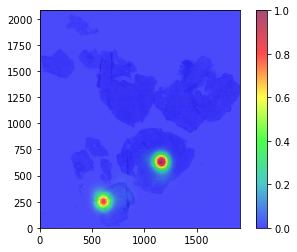

Elapsed Time: 351.4374 seconds


In [68]:
                                  ### IMAGE MATCHING FOR FOLDERS USING DESCRIPTORS
# Record the start time
start_time = time.time()

data_dict={}
zoomed_imgs = []     ####for zoomed images
zoomed_filenames=[]


zoomed_files = natsorted(os.listdir(zoomed_folder))
target_files = natsorted(os.listdir(target_folder))
for filename in zoomed_files:
    img = cv2.imread(os.path.join(zoomed_folder,filename))
    if img is not None:
        zoomed_imgs.append(img) 
        zoomed_filenames.append(filename)  
        
target_imgs = []     ####for original images
target_filenames=[]
for filename in target_files:
    img = cv2.imread(os.path.join(target_folder,filename))
    if img is not None:
        target_imgs.append(img)
        target_filenames.append(filename)
        
        fn = re.sub(r'\.(jpg|png)$', '', filename, flags=re.IGNORECASE)
        
        if fn not in data_dict:
            data_dict[fn]=[]
                 
arb=[]
# Set up SIFT detector and FLANN matcher
sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
a=0
# Loop through all image pairs and perform matching and transformation
for i in range(len(zoomed_imgs)):     ##zoomed
    img1 = cv2.cvtColor(zoomed_imgs[i], cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift.detectAndCompute(img1, None)   
    
    for j in range(len(target_imgs)):   #original
        img2 = cv2.cvtColor(target_imgs[j], cv2.COLOR_BGR2GRAY)
        kp2, des2 = sift.detectAndCompute(img2, None)
        matches = flann.knnMatch(des1, des2, k=2)
        
        # Apply ratio test to filter out poor matches
        good_matches = []
        for x, y in matches:
            if x.distance < 0.80 * y.distance:
                good_matches.append(x)
        #print(f'Number of good matches: {len(good_matches)}')
        if len(good_matches) > 4:
        # Apply RANSAC to estimate the transformation between the original image and the zoomed image
         src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
         dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
         M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Compute the accuracy of the match
         num_inliers = np.sum(mask)
         num_outliers = len(good_matches) - num_inliers
         accuracy = num_inliers / len(good_matches) * 100
       
         if accuracy> 60:  ##50 is better than 40 in some cases ..prefer 50
           x=target_filenames[j]
           y=zoomed_filenames[i]
           print("target filename",x)
           print("zoomed filename",y)
           arb.append([x,y])
           dat=search12(x,y,M)
            
print("final",dat)
heatmap(target_folder, data_dict)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

